In [20]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import ParameterGrid
from itertools import combinations

In [78]:
files = [f for f in os.listdir('DM_u0_5_10e6/') if 'results' in f and int(f.split('_')[-1].split('.')[0]) in landscape_0_inds]

In [79]:
all_results = []

for file in files:
    
    with open('DM_u0_5_10e6/'+file, 'rb') as f:
        result = pickle.load(f)
        
    for r in result:
        
        all_results.append({'m':r['m'], 'a1':r['ap'], 'q1':r['qd'], 'T':r['ttr'], 
                           'SM_control':r['Y_control'][1]+r['Y_control'][2], 
                           'SM_treatment':r['Y_treatment'][1]+r['Y_treatment'][2], 
                           'DM_control':r['Y_control'][-1],
                           'DM_treatment':r['Y_treatment'][-1]})
                           #'DM_control':r['Y_control'][1]+r['Y_control'][2]+r['Y_control'][-1],
                           #'DM_treatment':r['Y_treatment'][1]+r['Y_treatment'][2]+r['Y_treatment'][-1]})
        
df_all_results = pd.DataFrame(all_results)

In [80]:
with open('DM_u0_5_10e6/paramgrid_ERF_epistasis.txt', 'rb') as f:
    param_grid = pickle.load(f)
df_paramgrid = pd.DataFrame(param_grid)

In [81]:
landscape_0_inds = set(df_paramgrid[df_paramgrid['landscape_index'] == 0].index)

In [82]:
along_m = sorted(list(set(df_all_results['m'])))
along_ap = sorted(list(set(df_all_results['a1'])))
along_ttr = sorted(list(set(df_all_results['T'])))
along_qd = sorted(list(set(df_all_results['q1'])))
along_m.remove(20000)
along_ap.remove(7.8)
along_ttr.remove(5)
along_qd.remove(1-5*3e-6)
all_along_params = [('m',along_m), ('a1',along_ap), ('T',along_ttr), ('q1',along_qd)]
all_names_params = ['m', 'a1', 'T', 'q1']

In [83]:
all_colormap_params = list(combinations(all_along_params, 2))
all_colormap_names = list(combinations(all_names_params,2))

In [84]:
dict_other_vals = {'m':20000, 'a1': 7.8, 'q1':1-5*3e-6, 'T':5}
r1 = 1

In [85]:
all_matrices_for_cmap = []

for comb in all_colormap_params:
    params_axes = (comb[0][0], comb[1][0])
    print(params_axes)
    other_params = set(all_names_params)-set(params_axes)

    colormap_params = np.zeros((len(comb[0][1]), len(comb[1][1])))
    
    for xind in range(len(comb[0][1])):
        for yind in range(len(comb[0][1])):
            df_axes = df_all_results.copy()
            for p in other_params:
                df_axes = df_axes[df_axes[p] == dict_other_vals[p]]
            df_axes = df_axes[(df_axes[params_axes[0]] == comb[0][1][xind])&(df_axes[params_axes[1]] == comb[1][1][yind])]
            
            #num = list(df_axes['SM_treatment'])[0]+r1*list(df_axes['DM_treatment'])[0]
            #den = list(df_axes['SM_control'])[0]+r1*list(df_axes['DM_control'])[0]
            
            num = list(df_axes['DM_treatment'])[0]
            den = list(df_axes['DM_control'])[0]
            colormap_params[xind, yind] = num/den
            
    all_matrices_for_cmap.append(colormap_params)

('m', 'a1')
('m', 'T')
('m', 'q1')
('a1', 'T')
('a1', 'q1')
('T', 'q1')


In [86]:
indices_colormaps = []
for i in range(3):
    for j in range(2):
        indices_colormaps.append((i,j))
indices_colormaps = dict(zip(range(6), indices_colormaps))

In [87]:
def calculate_ticks(ticklabels, truerange, tickrange):
    tick_pos = []
    for l in ticklabels:
        NewValue = (((l - truerange[0]) * (tickrange[1] - tickrange[0])) / (truerange[1] - truerange[0])) + tickrange[0]
        tick_pos.append(NewValue)
    return(np.array(tick_pos))

def calculate_ticks_log(ticklabels, truerange, tickrange):
    tick_labels = np.log(ticklabels)
    true_range = np.log(truerange)
    tick_pos = []
    for l in ticklabels:
        NewValue = (((l - truerange[0]) * (tickrange[1] - tickrange[0])) / (truerange[1] - truerange[0])) + tickrange[0]
        tick_pos.append(NewValue)
    return(np.array(tick_pos))

In [88]:
param_ticks = {'m':[1500,5000,10000,15000,20000,25000,29900],
               'a1':[7.7,8.0,8.3,8.6,8.8],
               'q1':[1-5e-6,1-5*3e-6,1-5*5e-6,1-5*7.5e-6,1-5*1e-5], 
               'T':[0,3,7,10,14]}
param_ranges = {'m':[1500,29900],
                'a1':[7.7,8.8],
                'q1':[5e-6,5e-5],
                'T':[0,14]}

In [89]:
all_xticks, all_yticks = [],[]
all_xticklabels, all_yticklabels = [],[]

for i in range(6):
    
    x_param, y_param = all_colormap_names[i]

    if y_param == 'q1':
        ticks_y = calculate_ticks_log(1-np.array(param_ticks[y_param]), param_ranges[y_param], [0,19])
    else:
        ticks_y = calculate_ticks(np.array(param_ticks[y_param]), param_ranges[y_param], [0,19])
        
    if y_param == 'q1':
        labels_y = list(["{:.1e}".format(1-x) for x in np.array(param_ticks[y_param])])
    elif y_param == 'a1':
        labels_y = [np.round(x,2) for x in param_ticks[y_param]]
    else:
        labels_y = [int(np.round(x)) for x in param_ticks[y_param]]
        
    if x_param == 'q1': 
        ticks_x = 19-np.array(calculate_ticks_log(1-np.array(param_ticks[x_param]), param_ranges[x_param], [0,19])[::-1])
    else:
        ticks_x = 19-np.array(calculate_ticks(np.array(param_ticks[x_param]), param_ranges[x_param], [0,19])[::-1])
            

    if x_param == 'q1':
        labels_x = list(["{:.1e}".format(1-x) for x in np.array(param_ticks[x_param])])
    elif x_param == 'a1':
        labels_x = [np.round(x,2) for x in param_ticks[x_param]]
    else:
        labels_x = [int(np.round(x)) for x in param_ticks[x_param]]
    
    
    all_xticks.append(ticks_x)
    all_yticks.append(ticks_y)
    all_xticklabels.append(labels_x)
    all_yticklabels.append(labels_y)

In [90]:
params_description = {'m':'Number of lethal positions $m$',
                      'n':'Number of gain-of-function positions $n$',
                      'a1': 'Clearance rate in clearance phase $a_1$ (per day)',
                      'q1': 'Viral mutation rate under treatment $u_1$ (per bp)',
                      'T': 'Time of start of treatment'}

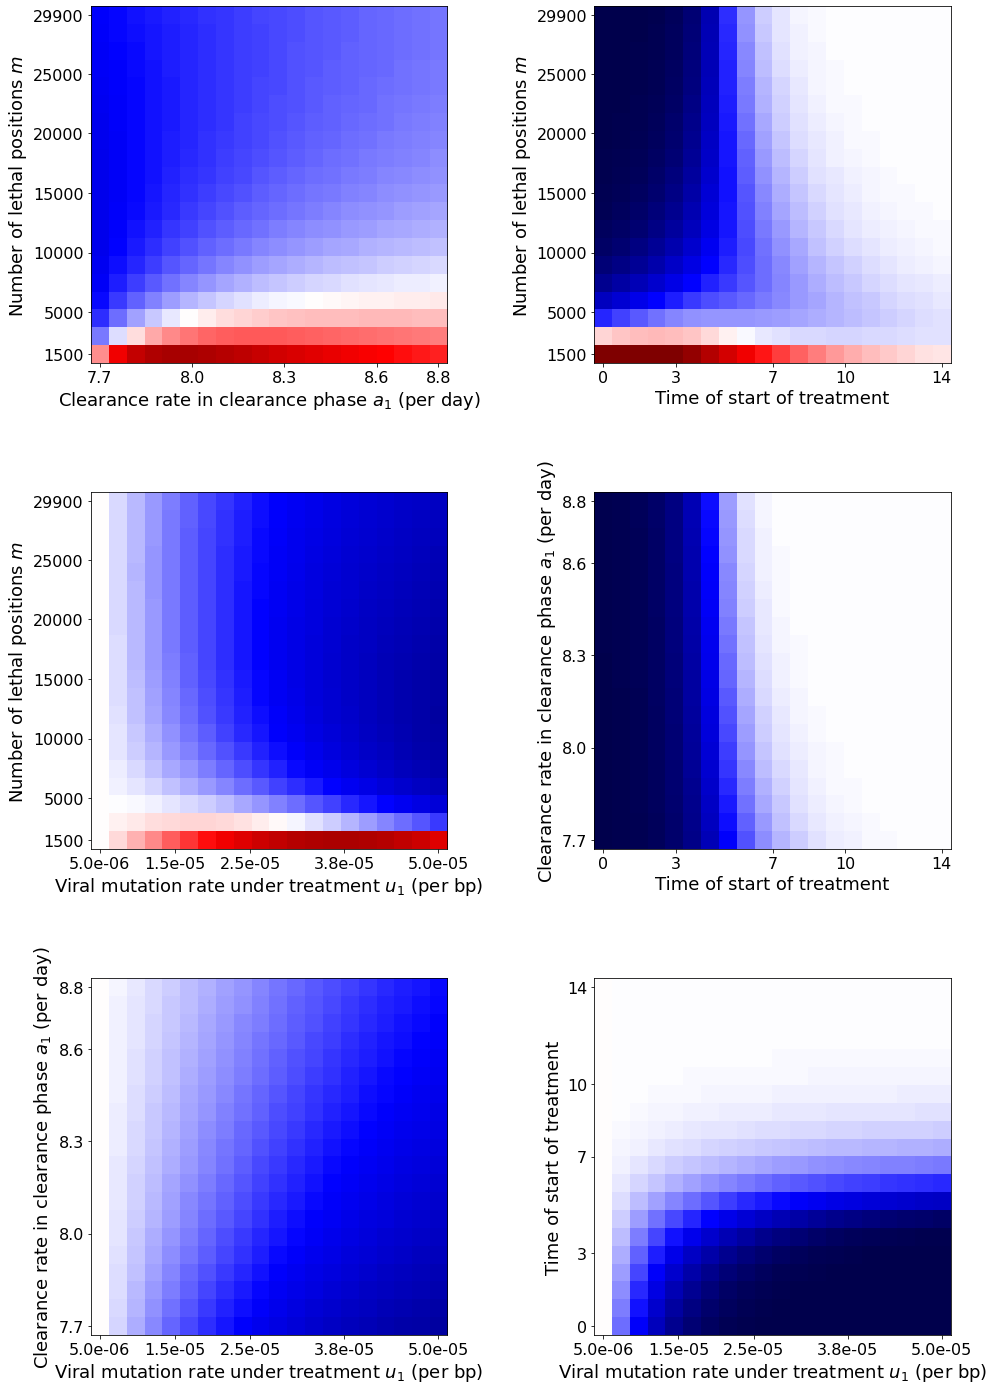

In [93]:
fig, ax = plt.subplots(3,2,figsize=(14,20))

for i in range(6):
    im = ax[indices_colormaps[i]].imshow(all_matrices_for_cmap[i][::-1], cmap = 'seismic', vmin = 0., vmax = 2)
    if all_colormap_params[i][1][0] in ['q1']:
        im = ax[indices_colormaps[i]].imshow(np.flip(all_matrices_for_cmap[i][::-1],1), cmap = 'seismic', vmin = 0., vmax = 2)

    ax[indices_colormaps[i]].set_xticks(all_yticks[i])
    ax[indices_colormaps[i]].set_xticklabels(all_yticklabels[i], fontsize = 16)
    
    ax[indices_colormaps[i]].set_yticks(all_xticks[i])
    ax[indices_colormaps[i]].set_yticklabels(all_xticklabels[i][::-1], fontsize = 16)    
    
    
    ax[indices_colormaps[i]].set_ylabel(params_description[all_colormap_params[i][0][0]], fontsize = 18)
    ax[indices_colormaps[i]].set_xlabel(params_description[all_colormap_params[i][1][0]], fontsize = 18)
    
    
plt.tight_layout(pad=3.0)
plt.savefig('_colormaps_fig5_epistasis_ERF_DM_5e6_onlyDm_JULY19.jpg', dpi = 600)

In [30]:
all_matrices_for_cmap

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1

In [31]:
df_all_results

,m,a1,q1,T,SM_control,SM_treatment,DM_control,DM_treatment
0,4489.473684,7.815789,0.999995,0.000000,6.755016e+06,6.755016e+06,1070.950540,1070.950540
1,4489.473684,7.815789,0.999995,0.736842,6.755016e+06,6.755016e+06,1070.950540,1070.950540
2,4489.473684,7.815789,0.999995,1.473684,6.755016e+06,6.755016e+06,1070.950540,1070.950540
3,4489.473684,7.815789,0.999995,2.210526,6.755016e+06,6.755016e+06,1070.950540,1070.950540
4,4489.473684,7.815789,0.999995,2.947368,6.755016e+06,6.755016e+06,1070.950540,1070.950540
...,...,...,...,...,...,...,...,...
1166881,25415.789474,8.047368,0.999985,11.789474,2.834275e+04,2.834275e+04,3.417724,3.417724
1166882,25415.789474,8.047368,0.999985,12.526316,2.834389e+04,2.834389e+04,3.418142,3.418142
1166883,25415.789474,8.047368,0.999985,13.263158,2.834433e+04,2.834433e+04,3.418316,3.418316
1166884,25415.789474,8.047368,0.999985,14.000000,2.834449e+04,2.834449e+04,3.418389,3.418389


In [1]:
(0.47**2)+(0.21**2)+(0.07**2)

0.2699

In [4]:
(0.5/9)/(0.5/20)

2.222222222222222

In [144]:
((1/3)*13.67 + (1/3)*18.17 + (1/3)*21.33 + (-1/2)*(8.67) + (-1/2)*11.33)**2

59.64987777777775

In [145]:
(1/6)*(3*(1/3)**2 + 2*(-0.5)**2)

0.13888888888888887

In [146]:
59.65/0.139

429.13669064748194

In [148]:
((-1/2)*13.67+(-1/2)*18.17+21.33)**2

29.26809999999996

In [149]:
(1/6)*(2*(1/2)**2+1)

0.25

In [150]:
29.268/0.25

117.072

In [151]:
(-8.67+11.33)**2

7.0756000000000006

In [152]:
(1/6)*(2)

0.3333333333333333

In [153]:
7.0756/(1/3)

21.2268

In [154]:
429.14/8.8867

48.29014144733141

In [155]:
117.072/8.8867

13.173844059099554

In [156]:
21.2268/8.8867

2.3886031935364085

In [157]:
(1/3)*12+(1/3)*11+(1/3)*10

11.0

In [158]:
30*(12-11)**2

30

In [159]:
1827.73/87

21.008390804597703

In [161]:
(11-10)/np.sqrt(21*2/30)

0.8451542547285166